# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

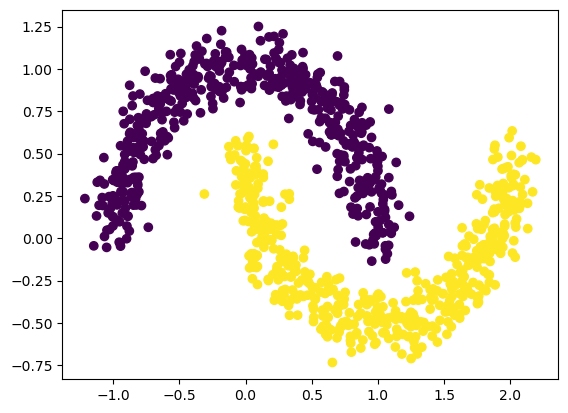

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:,0])

Train KAN

In [2]:
model = KAN(width=[2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.57e-01 | test loss: 1.60e-01 | reg: 3.63e+00 : 100%|██| 20/20 [00:01<00:00, 14.50it/s]


(0.9990000128746033, 0.9990000128746033)

Automatic symbolic regression

In [3]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.975803017616272, c=2
fixing (0,1,0) with x, r2=0.9723848104476929, c=1


-0.8594*x_2 - 0.3941*sin(3.0987*x_1 - 1.5582) + 0.7172

How accurate is this formula?

In [4]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(1.)
test acc of the formula: tensor(0.9990)


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

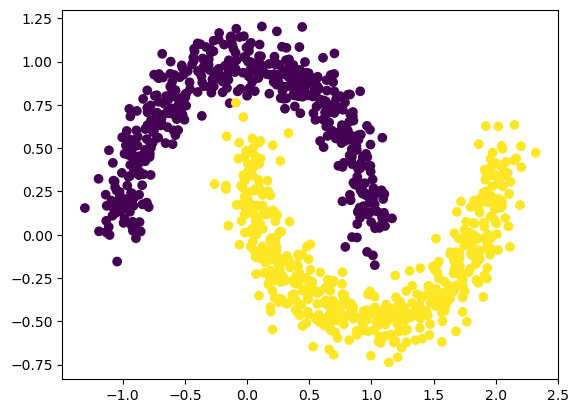

In [5]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:])

### Train KAN

In [6]:
model = KAN(width=[2,2], grid=3, k=3)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

train loss: 3.94e-05 | test loss: 5.00e-01 | reg: 1.52e+04 : 100%|██| 20/20 [00:02<00:00,  9.35it/s]


Automatic symbolic regression

In [7]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9947189092636108, c=2
fixing (0,0,1) with sin, r2=0.9957412481307983, c=2
fixing (0,1,0) with x, r2=0.8554980754852295, c=1
fixing (0,1,1) with x, r2=0.8216891884803772, c=1


In [8]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

1603.3414*x_2 - 10662.2939*sin(2.098*x_1 + 8.1668) - 2805.9184

In [9]:
ex_round(formula2, 4)

-858.4062*x_2 + 10339.7666*sin(1.8559*x_1 - 7.4117) - 2037.7221

How accurate is this formula?

In [10]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9940)
test acc of the formula: tensor(0.9970)
